In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
def standardize_data(X, mean = None, std = None):
    if mean is None:
        mean = X.mean()
    if std is None:
        std = X.std()
    x_s = (X - mean) / std
    return x_s, mean, std

In [6]:
df = pd.read_csv('date_promovare_examen.csv')
df.dropna(inplace=True)

y = df['Promovare'].values.astype(float)
x_1 = df['Ore_Studiu'].values.astype(float) # ore studiu
x_1 = x_1 - x_1.mean()
x_2 = df['Ore_Somn'].values.astype(float) # ore somn
x_2 = x_2 - x_2.mean()

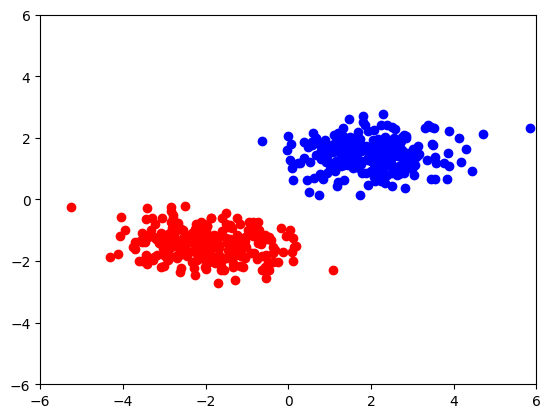

In [18]:
plt.xlim(-6,6)
plt.ylim(-6,6)

plt.scatter(x_1[y == 1], x_2[y == 1], color='blue')
plt.scatter(x_1[y == 0], x_2[y == 0], color='red')

plt.show()

In [ ]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta_1 = pm.Normal('beta_1', mu=0, sigma=3)
    beta_2 = pm.Normal('beta_2', mu=0, sigma=3)
    
    mu = alpha + beta_1 * x_1 + beta_2 * x_2
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    bd = pm.Deterministic('bd', -alpha / beta_2 - beta_1 / beta_2 * x_1)
    
    y_data = pm.Bernoulli('y_data', p=theta, observed=y)
    trace = pm.sample(2000,return_inferencedata=True)

In [20]:
print(az.summary(trace,var_names=['alpha', 'beta_1', 'beta_2']))

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha   0.382  1.421  -2.348    3.013      0.031    0.024    2119.0    1914.0   
beta_1  2.660  1.036   0.770    4.532      0.023    0.016    2069.0    2213.0   
beta_2  4.853  1.545   2.242    7.807      0.038    0.028    1911.0    1684.0   

        r_hat  
alpha     1.0  
beta_1    1.0  
beta_2    1.0  


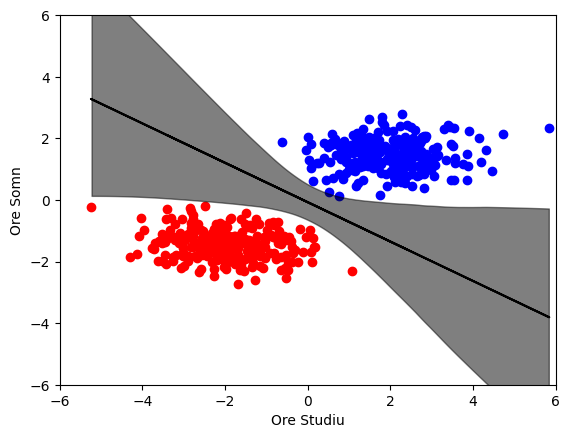

In [21]:
idx = np.argsort(y)
bd = trace.posterior['bd'].mean(("chain", "draw"))[idx]
plt.scatter(x_1[y == 1], x_2[y == 1], color='blue')
plt.scatter(x_1[y == 0], x_2[y == 0], color='red')

plt.xlim(-6,6)
plt.ylim(-6,6)
plt.plot(x_1[idx], bd, color='k')
az.plot_hdi(x_1, trace.posterior['bd'], color='k')

plt.xlabel('Ore Studiu')
plt.ylabel('Ore Somn')

plt.show()